In [123]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_federated as tff

In [101]:
def plot_client(client_id, ds, image_getter, label_getter):
    np.random.seed(42)
    fig = plt.figure(figsize=(5,5))
    subplts = fig.subplots(2, 2)
    client_ds = list(iter(ds.create_tf_dataset_for_client(client_id)))
    # fig.suptitle(f"Client {client_id} ({len(client_ds)} images)")
    client_img_sample = np.random.choice(client_ds, size=4, replace=False)
    for i, subplt in enumerate(subplts.flatten()):
        subplt.imshow(image_getter(client_img_sample[i]), cmap='gray')
        subplt.set_xlabel(label_getter(client_img_sample[i]))
        subplt.set_yticklabels([])
        subplt.set_xticklabels([])
        subplt.set_yticks([])
        subplt.set_xticks([])
    print((client_id, len(client_ds)))
    plt.show()

In [241]:
def create_label_dataframe(ds, label_getter):
    labels_per_client = {
        client_id : list(map(label_getter, iter(ds.create_tf_dataset_for_client(client_id))))
        for client_id in ds.client_ids
    }

    return pd.DataFrame([(c, l) for c in labels_per_client.keys() for l in labels_per_client[c]], columns=['client_id', 'label'])

In [257]:
def plot_label_dist_for_clients(label_df, client_ids):
    label_counts = (
        label_df
        .groupby(['client_id', 'label'])
        .value_counts()
        .reset_index()
        .pivot(index='client_id', columns='label', values='count')
        .fillna(0)
    )

    def prepare_axis(ax, ax_num):
        if not (ax_num == 0):
            ax.tick_params(left=False)
            ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.tick_params(labelbottom=False)

    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(ncols=len(client_ids), sharey=True, sharex=True, squeeze=True)
    for i, ax in enumerate(axes):
        prepare_axis(ax, i)
    for ax, (cid, labels) in zip(axes, label_counts.loc[client_ids].iterrows()):
        labels.plot(kind='bar', sharey=True, sharex=True, fig=fig, ax=ax, title=f"Client {cid}", xlabel='')

In [307]:
def get_label_statistics(label_df):
    return {
        'num_examples': len(label_df),
        'num_classes': label_df['label'].nunique(),
        'num_clients': label_df['client_id'].nunique(),
        'mean_samples_per_client': label_df['client_id'].value_counts().mean(),
        'stddev_samples_per_client': label_df['client_id'].value_counts().std(),
        'mean_classes_per_client': label_df.groupby(['client_id']).agg({'label': 'nunique'}).mean().item(),
        'stddev_classes_per_client': label_df.groupby(['client_id']).agg({'label': 'nunique'}).std().item(),
    }

# EMNIST

In [263]:
train_ds, test_ds = tff.simulation.datasets.emnist.load_data(only_digits=True)

In [264]:
np.random.seed(42)
emnist_clients = np.random.choice(train_ds.client_ids, size=5, replace=False)
image_getter = lambda x: x['pixels'].numpy()
label_getter = lambda x: x['label'].numpy()

In [266]:
emnist_label_df = create_label_dataframe(train_ds, label_getter)
emnist_label_df

,client_id,label
0,f0000_14,1
1,f0000_14,0
2,f0000_14,0
3,f0000_14,1
4,f0000_14,1
...,...,...
341868,f4099_10,4
341869,f4099_10,4
341870,f4099_10,7
341871,f4099_10,7


<Axes: xlabel='label'>

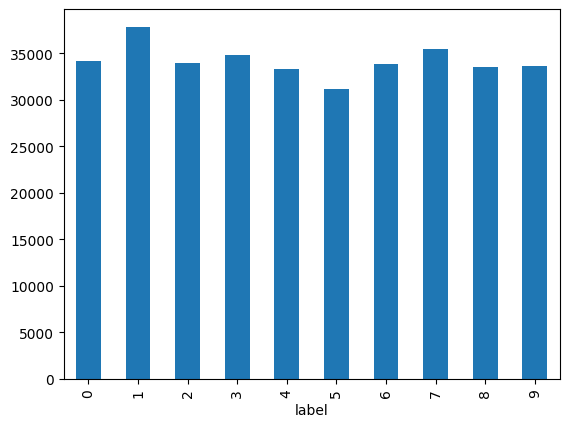

In [267]:
emnist_label_df['label'].value_counts().sort_index().plot(kind='bar')

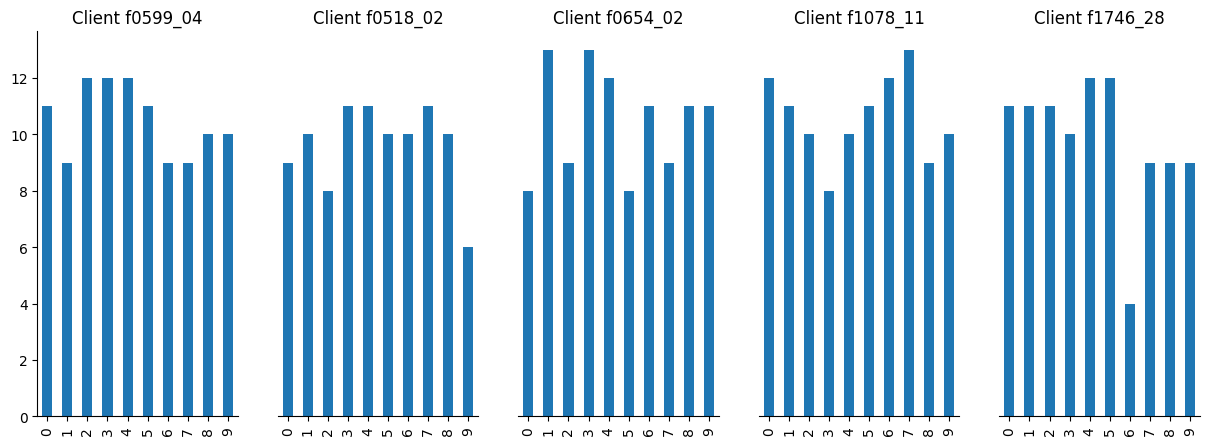

In [268]:
plot_label_dist_for_clients(emnist_label_df, emnist_clients)

('f0599_04', 105)


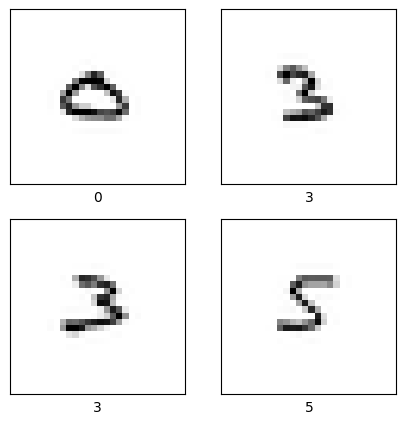

('f0518_02', 96)


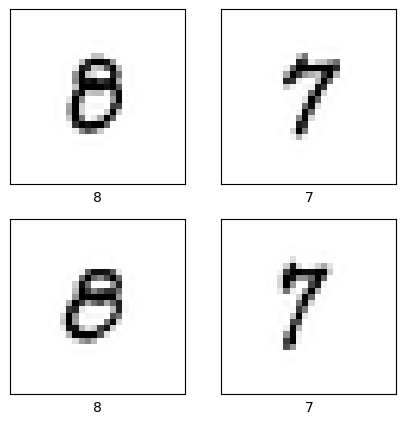

('f0654_02', 105)


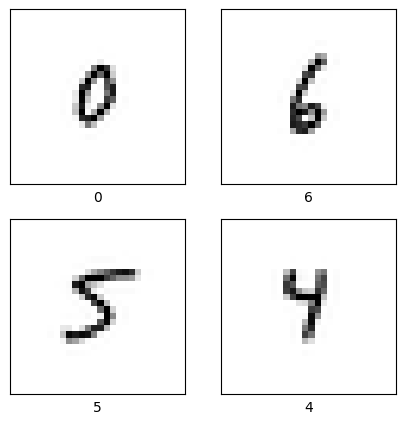

('f1078_11', 106)


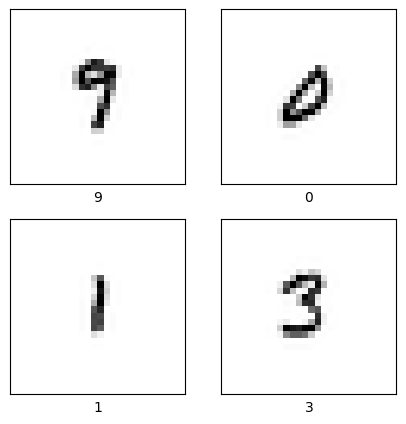

('f1746_28', 98)


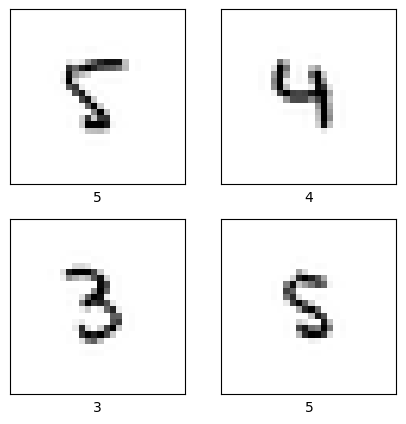

In [265]:
for client in emnist_clients:
    plot_client(client, train_ds, image_getter, label_getter)

# SVHN

In [104]:
SVHN_DIR = os.path.join(os.path.expanduser("~"), ".tff/svhn")

def _load_svhn():
    svhn_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(SVHN_DIR) / 'train.sqlite'), element_spec=svhn_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(SVHN_DIR) / 'test.sqlite'), element_spec=svhn_spec, split_name=None)
    return train_client_data, test_client_data

In [244]:
train_ds, test_ds = _load_svhn()
image_getter = lambda x: x['image'].numpy()
label_getter = lambda x: x['label'].numpy()

In [106]:
np.random.seed(42)
svhn_clients = np.random.choice(train_ds.client_ids, size=5, replace=False)

In [245]:
svhn_label_df = create_label_dataframe(train_ds, label_getter)
svhn_label_df

,client_id,label
0,client_0,3
1,client_0,5
2,client_0,9
3,client_0,8
4,client_0,8
...,...,...
26027,client_99,2
26028,client_99,6
26029,client_99,1
26030,client_99,1


<Axes: xlabel='label'>

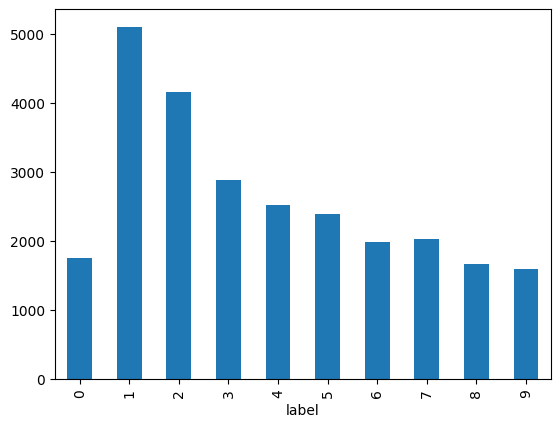

In [260]:
svhn_label_df['label'].value_counts().sort_index().plot(kind='bar')

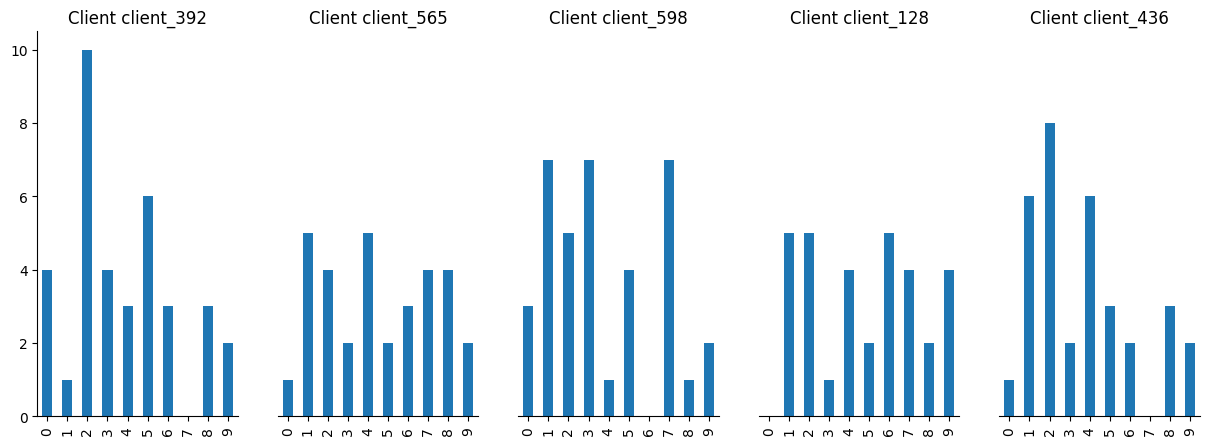

In [259]:
plot_label_dist_for_clients(svhn_label_df, svhn_clients)

('client_392', 36)


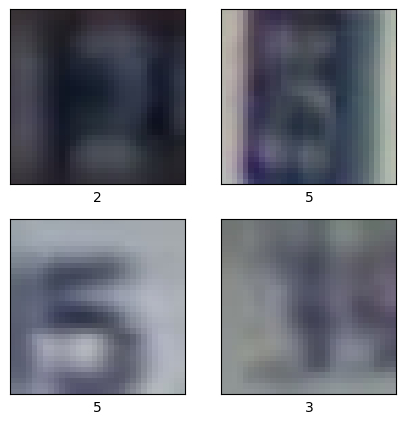

('client_565', 32)


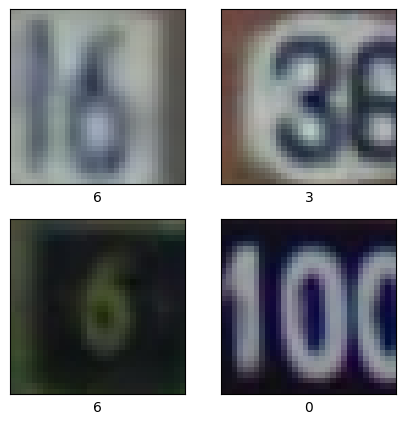

('client_598', 37)


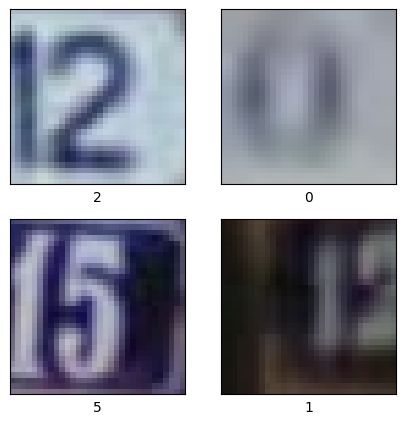

('client_128', 32)


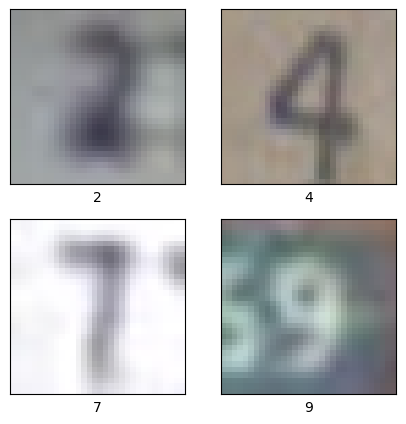

('client_436', 33)


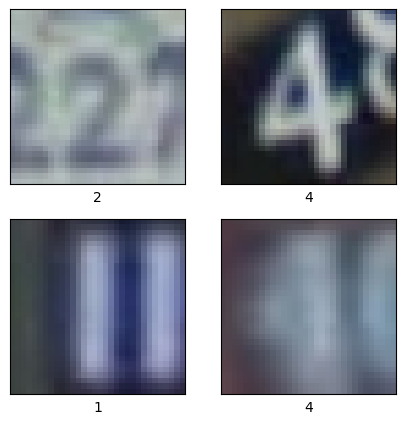

In [107]:
for client in svhn_clients:
    plot_client(client, train_ds, image_getter, label_getter)

# CIFAR-100

In [113]:
fine_label_to_str = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
coarse_label_to_str = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']

In [270]:
train_ds, test_ds = tff.simulation.datasets.cifar100.load_data()

In [271]:
np.random.seed(42)
cifar_clients = np.random.choice(train_ds.client_ids, size=5, replace=False)
image_getter = lambda x: x['image'].numpy()
label_getter = lambda x: x['coarse_label'].numpy()

In [274]:
cifar_label_df = create_label_dataframe(train_ds, lambda x: x['coarse_label'].numpy())
cifar_label_df

,client_id,label
0,0,4
1,0,4
2,0,4
3,0,8
4,0,10
...,...,...
49995,99,15
49996,99,15
49997,99,15
49998,99,15


<Axes: xlabel='label'>

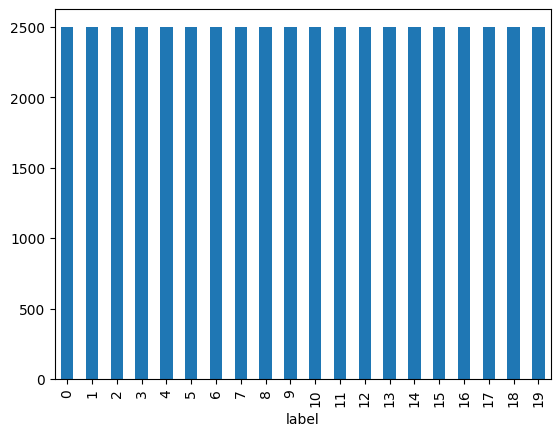

In [275]:
cifar_label_df['label'].value_counts().sort_index().plot(kind='bar')

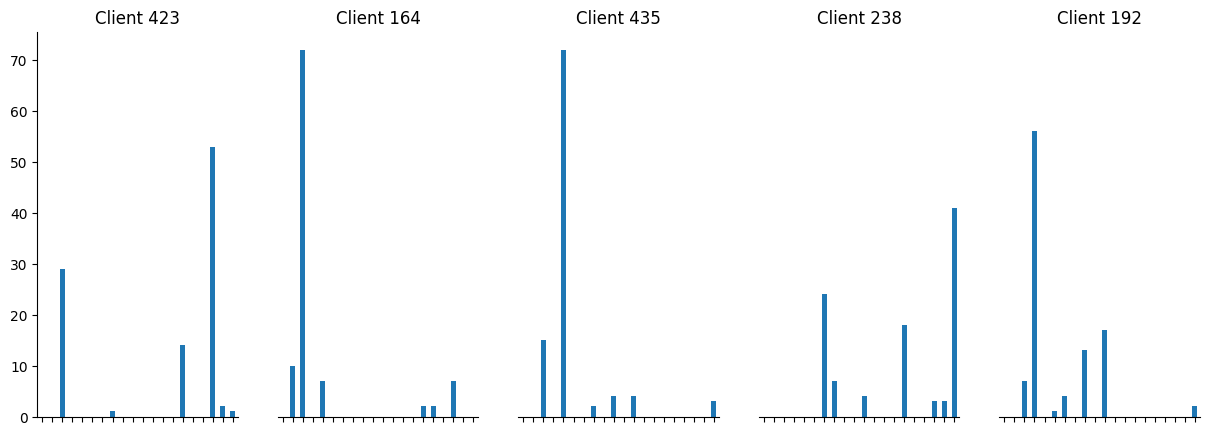

In [254]:
plot_label_dist_for_clients(cifar_label_df, cifar_clients)

('423', 100)


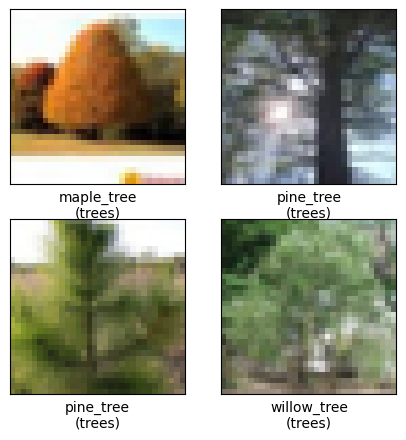

('164', 100)


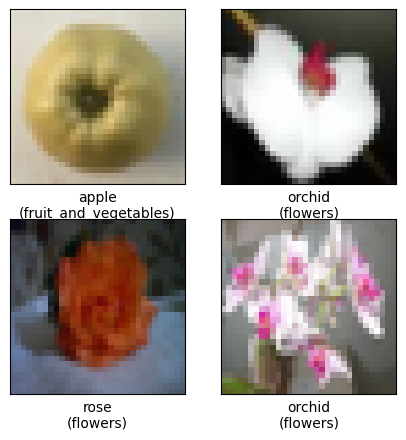

('435', 100)


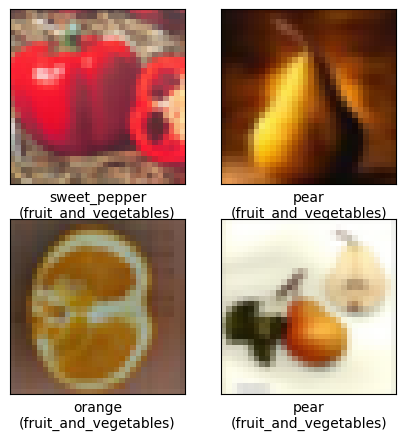

('238', 100)


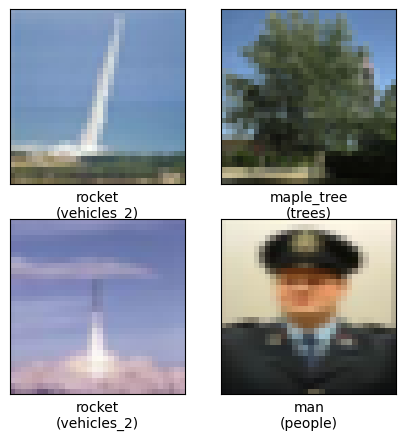

('192', 100)


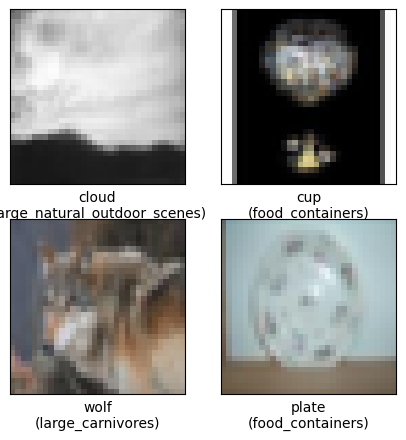

In [273]:
label_getter = lambda x: f"{fine_label_to_str[x['label'].numpy()]}\n({coarse_label_to_str[x['coarse_label'].numpy()]})"
for client in cifar_clients:
    plot_client(client, train_ds, image_getter, label_getter)

# Summary Statistics

In [308]:
ds = [('emnist', emnist_label_df), ('svhn', svhn_label_df), ('cifar', cifar_label_df)]
pd.DataFrame([{'dataset': n, **get_label_statistics(d)} for n, d in ds])

,dataset,num_examples,num_classes,num_clients,mean_samples_per_client,stddev_samples_per_client,mean_classes_per_client,stddev_classes_per_client
0,emnist,341873,10,3383,101.056163,14.727340,9.991723,0.139451
1,svhn,26032,10,725,35.906207,5.895455,9.449655,0.762929
2,cifar,50000,20,500,100.000000,0.000000,6.532000,1.993219
